## Model Selection and HyperParameter Tuning

In [ ]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import joblib


In [12]:
preprocessed_data_path = 'preprocessed_data_without_text.csv'
preprocessed_data = pd.read_csv(preprocessed_data_path)

In [ ]:
from sklearn.model_selection import train_test_split

y = preprocessed_data['category']
X = preprocessed_data.drop(columns=['category'])

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

## Handling Imbalanced Dataset

Attempted to annotate data to deal with high volume of wrongly predicted 'Uncategorized' class. But metrics show no improvement.

- Oversample and undersample to strike a balance between classes
- Reduce size to mitigate model training runtime

In [ ]:
# Oversampling and Undersampling Strategy

max_samples = 20000  # upper limit for large categories
min_samples = 1000   # lower limit for small categories

# compute class distribution in training set
class_counts = np.bincount(y_train)  # Count occurrences of each class
classes = np.unique(y_train)

# define sampling strategies dynamically
smote_strategy = {}
undersample_strategy = {cls: int(count * 0.7) for cls, count in y_train.value_counts().items()}

for cls, count in zip(classes, class_counts):
    if count < min_samples:
        smote_strategy[cls] = min_samples  
    elif count > max_samples:
        undersample_strategy[cls] = max_samples  

k_neighbors = min(3, min(class_counts) - 1) 

smote = SMOTE(sampling_strategy=smote_strategy, k_neighbors=k_neighbors)
undersample = RandomUnderSampler(sampling_strategy=undersample_strategy)

resampling_pipeline = Pipeline([
    ('smote', smote),
    ('undersample', undersample)
])

X_train_resampled, y_train_resampled = resampling_pipeline.fit_resample(X_train, y_train)


c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args,

In [7]:
X_train_resampled.shape

(115917, 35)

In [ ]:
X_train_resampled, y_train_resampled = resampling_pipeline.fit_resample(X_train, y_train)

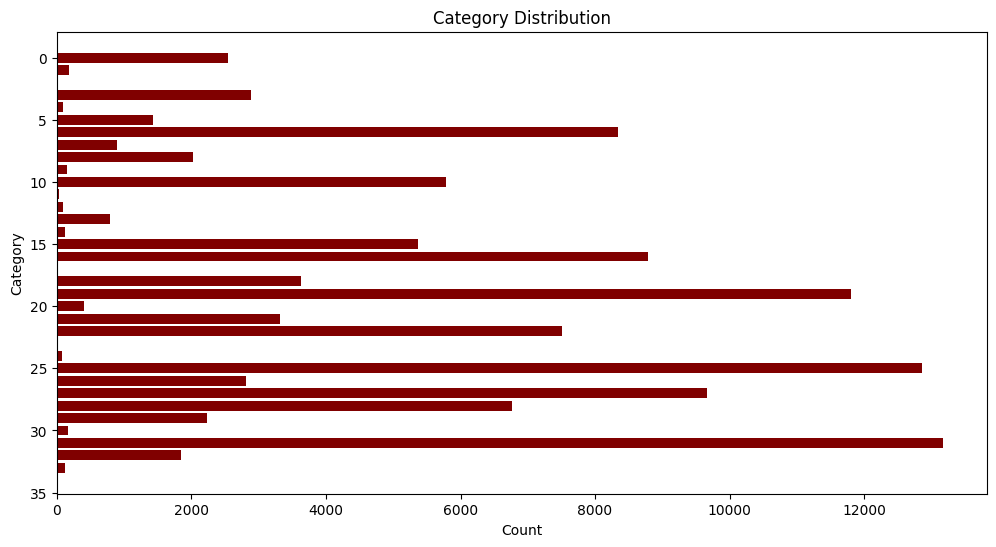

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert y_pred to a Pandas Series
y_train_resampled = pd.Series(y_train_resampled)

# Get category distribution
label = y_train_resampled.value_counts().index
values = y_train_resampled.value_counts().values

# Map encoded labels back to original category names (if needed)
if isinstance(label[0], (int, float)):  # Check if labels are numeric
    label = [class_mapping[lbl] for lbl in label]  # Convert to original labels

# Plot the distribution
plt.figure(figsize=(12, 6))
plt.barh(label, values, color="maroon")
plt.xlabel("Count")
plt.ylabel("Category")
plt.title("Category Distribution")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


## Algorithm Selection 

In [11]:
# Define the models to test
models = {
    'Logistic Regression': LogisticRegression(),
    # 'SVC': SVC(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

# Loop through models, train and evaluate each
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Calculate metrics for validation set
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Calculate metrics for test set
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Print the metrics
    print(f"Model: {name}")
    print("Validation Metrics:")
    print(f"F1 Score: {val_f1:.4f}")
    print(f"Precision: {val_precision:.4f}")
    print(f"Recall: {val_recall:.4f}")
    print(f"Accuracy: {val_accuracy:.4f}")
    print()
    print("Test Metrics:")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"Accuracy: {test_accuracy:.4f}")
    print("-" * 50)


# If you'd like to compare just accuracy, you can sort models by accuracy
accuracy_comparison = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

print("Accuracy comparison across models:")
for name, result in accuracy_comparison:
    print(f"{name}: {result['accuracy']}")


c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\V37

Model: Logistic Regression
Validation Metrics:
F1 Score: 0.0943
Precision: 0.0660
Recall: 0.1690
Accuracy: 0.1690

Test Metrics:
F1 Score: 0.0957
Precision: 0.0670
Recall: 0.1716
Accuracy: 0.1716
--------------------------------------------------


c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Random Forest
Validation Metrics:
F1 Score: 0.6828
Precision: 0.6911
Recall: 0.6867
Accuracy: 0.6867

Test Metrics:
F1 Score: 0.6821
Precision: 0.6903
Recall: 0.6865
Accuracy: 0.6865
--------------------------------------------------


c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: KNN
Validation Metrics:
F1 Score: 0.1667
Precision: 0.1746
Recall: 0.1668
Accuracy: 0.1668

Test Metrics:
F1 Score: 0.1681
Precision: 0.1775
Recall: 0.1678
Accuracy: 0.1678
--------------------------------------------------


c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Naive Bayes
Validation Metrics:
F1 Score: 0.0162
Precision: 0.0534
Recall: 0.0901
Accuracy: 0.0901

Test Metrics:
F1 Score: 0.0163
Precision: 0.0607
Recall: 0.0902
Accuracy: 0.0902
--------------------------------------------------


c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Gradient Boosting
Validation Metrics:
F1 Score: 0.5571
Precision: 0.5893
Recall: 0.5601
Accuracy: 0.5601

Test Metrics:
F1 Score: 0.5579
Precision: 0.5890
Recall: 0.5617
Accuracy: 0.5617
--------------------------------------------------


c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Decision Tree
Validation Metrics:
F1 Score: 0.6260
Precision: 0.6263
Recall: 0.6259
Accuracy: 0.6259

Test Metrics:
F1 Score: 0.6271
Precision: 0.6272
Recall: 0.6272
Accuracy: 0.6272
--------------------------------------------------
Model: AdaBoost
Validation Metrics:
F1 Score: 0.1964
Precision: 0.2369
Recall: 0.2483
Accuracy: 0.2483

Test Metrics:
F1 Score: 0.1962
Precision: 0.2347
Recall: 0.2482
Accuracy: 0.2482
--------------------------------------------------
Accuracy comparison across models:


c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Best Model: Random Forest

## Hyperparameter Tuning with Optuna

In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


def objective(trial):
    """Objective function to optimize Random Forest hyperparameters."""
    
    # hyperparameter space
    n_estimators = trial.suggest_int("n_estimators", 50, 500) 
    max_depth = trial.suggest_int("max_depth", 3, 30)  
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)  
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)  
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])  
    
    # define and train the Random Forest model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_val)

    # compute weighted F1-score
    f1 = f1_score(y_val, y_pred, average="weighted")
    
    return f1  


In [ ]:
study = optuna.create_study(direction="maximize")  # Maximize F1-score
study.optimize(objective, n_trials=50)  # Run 50 trials

# Best parameters
print("Best Hyperparameters:", study.best_params)
print("Best F1 Score:", study.best_value)


[I 2025-02-10 19:54:03,411] A new study created in memory with name: no-name-d1baefbb-73ef-476d-ac80-33ce9e322315
[I 2025-02-10 19:54:19,350] Trial 0 finished with value: 0.5913757647928425 and parameters: {'n_estimators': 182, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5913757647928425.
[I 2025-02-10 19:54:38,605] Trial 1 finished with value: 0.4688296155401625 and parameters: {'n_estimators': 375, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5913757647928425.
[I 2025-02-10 19:55:45,770] Trial 2 finished with value: 0.31618785373085473 and parameters: {'n_estimators': 478, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 0 with value: 0.5913757647928425.
[I 2025-02-10 19:55:54,594] Trial 3 finished with value: 0.48701052722617866 and parameters: {'n_estimators': 197, 'max_depth': 10, '

Best Hyperparameters: {'n_estimators': 267, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}
Best F1 Score: 0.6542367765718023


In [ ]:
best_params = study.best_params

best_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)

# save the model param to a pickle file
joblib.dump(best_model, "best_random_forest.pkl")
